# CWN temporal evolution

* In this notebook a set of frames is generated for the ego network of a collector (Munhoz, CBR)

In [1]:
# Setting paths
import sys,os
import pathlib
sys.path.insert(0,os.path.expanduser('~/caryocar'))
sys.path.insert(0,os.path.abspath('..'))

In [2]:
# Building the networks from data
from setupmodels import *

In [3]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib as mpl
import seaborn as sns
import scipy as scp 

import matplotlib.pyplot as plt

from collections import Counter

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('seaborn-paper')
sns.set_color_codes('deep')

In [4]:
# plot style params
sns.set_color_codes('deep')
plt.rc('figure', figsize=(8,5))

---

In [5]:
# Globals
OCCS = occs # occurrences
CWN = cwn # the entire CWN 
NI = ni # names index
NM = nm # names map

# Global pd Series
OCCS['eventDate'] = pd.to_datetime(OCCS['eventDate'])
RECORDS_DATES = OCCS['eventDate'].sort_values() # dataset with row ids and event dates
RECORDS_DATES.index.name='id'

TEAMS_TS = OCCS.set_index(['eventDate'])
TEAMS_TS.sort_index(inplace=True)
TEAMS_TS = TEAMS_TS['recordedBy_atomized']

# Helper expressions
count_records_upto = lambda year, col: (RECORDS_DATES[NI[col]].dropna()<=str(year)).sum()

In [6]:
def buildCWN(collectorsSet, yearsSlice, central_collector=None, collaborations_only=False):
    cwn = CoworkingNetwork(cliques=TEAMS_TS[yearsSlice], namesMap= NM)
    cwn.remove_nodes_from( set(cwn.nodes()).difference(set(collectorsSet)) )

    
    # Only include collectors who collaborated with the central collectors (if passed)
    if central_collector is not None and collaborations_only==True:
        try:
            to_remove = set(collectorsSet) -  set(cwn[central_collector]) - {central_collector} 
            cwn.remove_nodes_from(to_remove)
        except KeyError: # In case the central collector is not passed
            cwn.remove_nodes_from(collectorsSet)
    
    return cwn

In [7]:
def buildFramesData( collectors, yearsSlices, central_collector=None, collaborations_only=False ):
    framesData = dict()
    for i, ySlice in enumerate(yearsSlices):
        framesData[i] = dict()
        framesData[i]['years'] = ySlice
        cwn = buildCWN( collectors, ySlice, central_collector, collaborations_only )
        nx.set_node_attributes( cwn, dict( (n,count_records_upto(ySlice.stop, n)) for n in cwn.nodes() ),'count' )
        framesData[i]['cwn'] = cwn
        framesData[i]['central_collector']=central_collector
    
    return framesData

In [8]:
def renderFrame(  i, fdata,pos,axis=None ):
    
    # define min and max x and y
    xs, ys = list(zip(*pos.values()))
    minx, maxx, miny, maxy =  min(xs), max(xs), min(ys), max(ys)
    
    # render the frame
    plt.figure(figsize=(10,10))
    plt.axis('off')
    cwn = fdata['cwn']
    if len(cwn.nodes)>0: # Plot nodes if there are nodes to plot
        nodes,nodesizes = zip(*[ node_size for node_size in cwn.nodes(data='count') ])
        nodecolors = [ 'b' if fdata['central_collector']==n else 'r' for n in nodes ]
        rescale = lambda x: 0.5*x
        nx.draw_networkx_nodes(cwn,pos,nodelist=nodes,node_size=list(map(rescale,nodesizes)),node_color=nodecolors, alpha=0.5,ax=axis)
        nx.draw_networkx_labels(cwn,pos,labels=dict( (n,n) for n,cnt in cwn.nodes(data='count') if cnt>50), ax=axis)

    if len(cwn.edges)>0: # Plot edges if there are edges to plot
        edges,edgesizes = zip(*[ ((u,v),size) for u,v,size in cwn.edges(data='weight_hyperbolic') ])
        rescale = lambda x: 0.01*x
        nx.draw_networkx_edges(cwn,pos,edgelist=edges, width=list(map(rescale,edgesizes)),ax=axis )


    if axis is not None:
        axis.set_xlim((minx-0.1,maxx+0.1))
        axis.set_ylim((miny-0.1,maxy+0.1))
        axis.set_title('{} - {}'.format(fdata['years'].start, fdata['years'].stop),pad=-20, size=16)
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)
        
    else:
        plt.xlim((minx-0.1,maxx+0.1))
        plt.ylim((miny-0.1,maxy+0.1))
        plt.title('{} - {}'.format(fdata['years'].start, fdata['years'].stop))
        plt.savefig(f'anim/frame{i}.png')
    
    return # return the ax

In [34]:
def renderFrames( pos, collectors, yearsSlices, central_collector=None, collaborations_only=False ):
    framesData = buildFramesData(collectors, yearsSlices, central_collector, collaborations_only)
    
    f, axes = plt.subplots(nrows=4, ncols=2, figsize=(20,35))
    f.subplots_adjust(wspace=5e-5)
    f.subplots_adjust(hspace=5e-5)
    axes = [ ax for axs in axes for ax in axs]
    # make frames
    for i,fdata in framesData.items():
        renderFrame(i,fdata,pos,axes[i]) # do not pass axis if to be rendered as frames
        
    return f

In [28]:
def collectorEvolution( collector, freq='A', min_year=None, max_year=None ):
    
    central_node = collector
    egoNet = nx.ego_graph(CWN, central_node)
    
    # fix names index (avoiding nulls)
    NI[central_node] = set(NI[central_node]) & set(RECORDS_DATES.index)
    
    # Get max and min years to slice
    min_year = RECORDS_DATES[NI[central_node]].min().year if min_year is None else min_year
    max_year = RECORDS_DATES[NI[central_node]].max().year if max_year is None else max_year
    
    # Define years slices
    years = pd.period_range(start=min_year,end=max_year,freq=freq)
    slices = [ slice( str(years[i-1].year), str(years[i].year-1)) for i in range(1,len(years)) ]
    slices.append(slice( str(years[-1].year), str(years[-1].year)))
    
    # Get layoyt and render frames
    pos = nx.layout.spring_layout(egoNet, pos={central_node:(0,0)}, fixed=[central_node], center=(0,0))
    return renderFrames( pos, list(egoNet.nodes()), slices, central_collector=collector, collaborations_only=True)

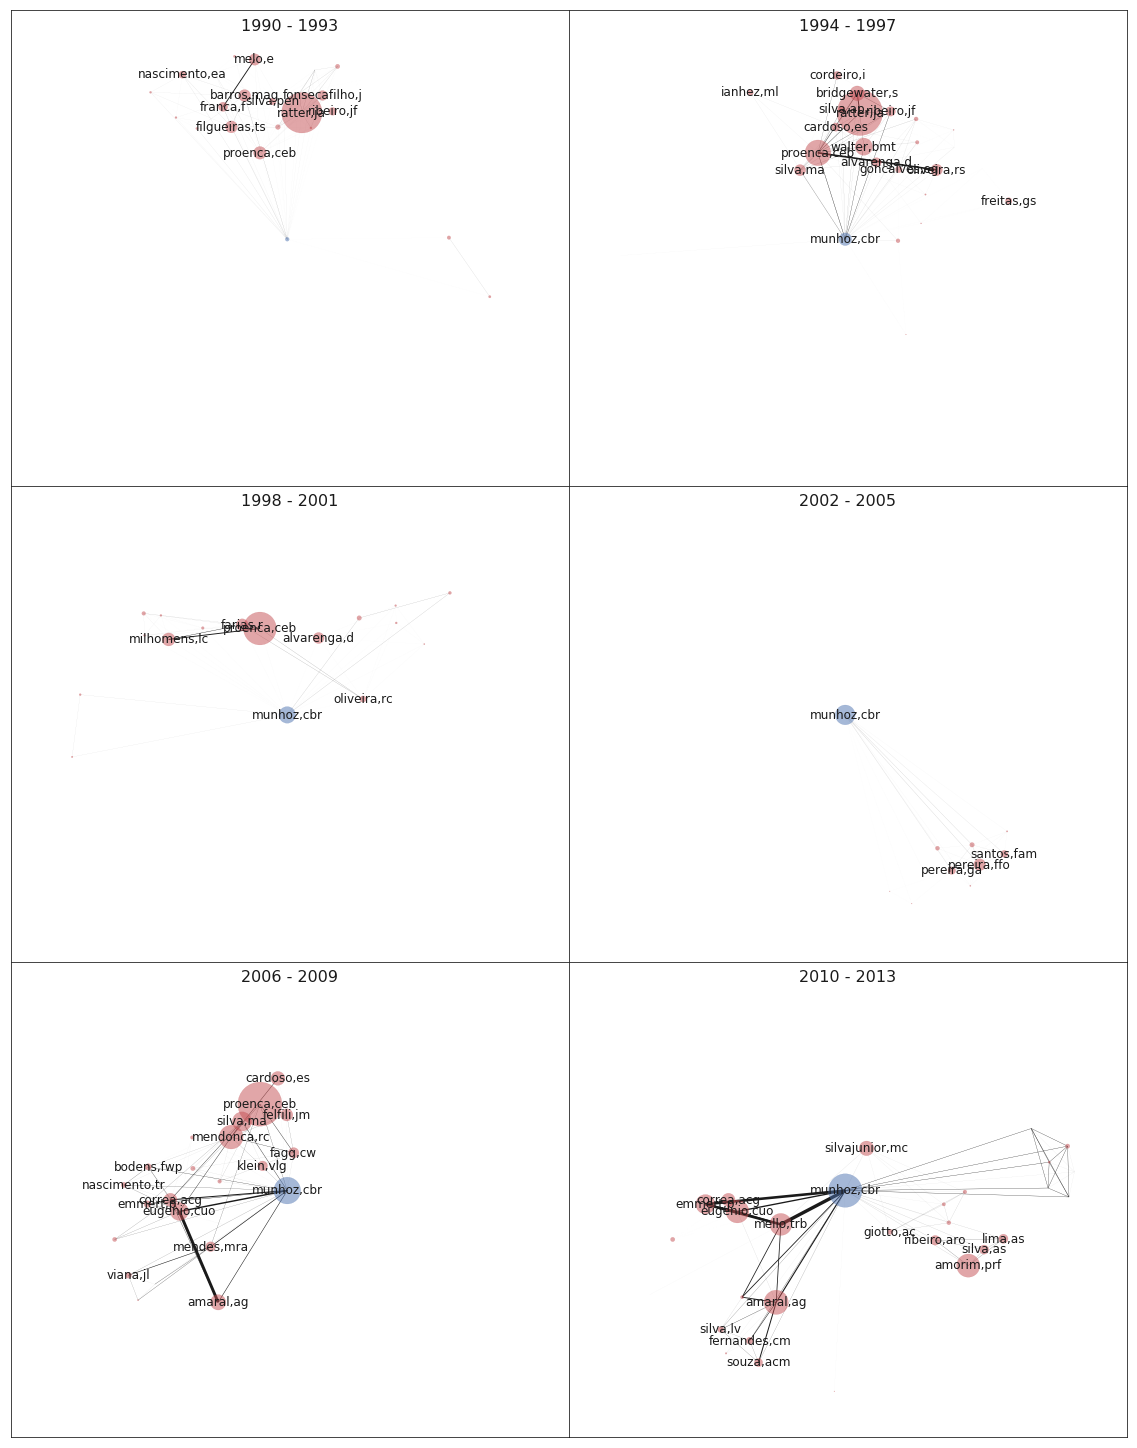

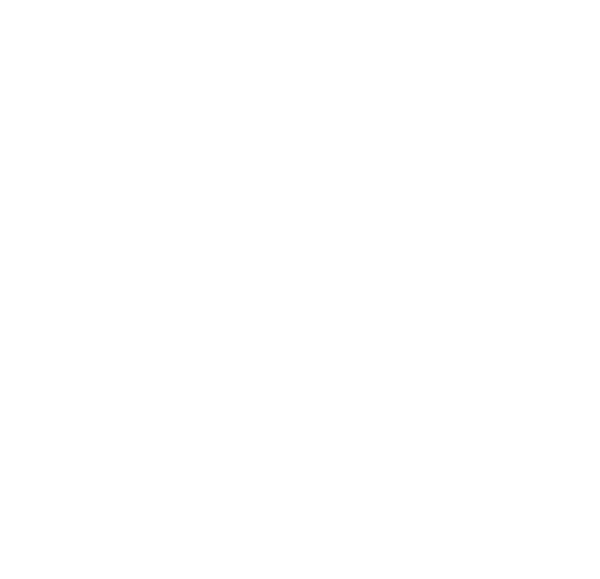

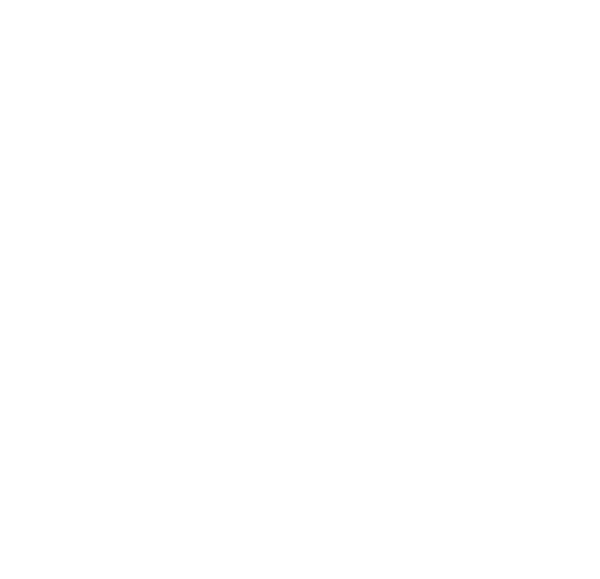

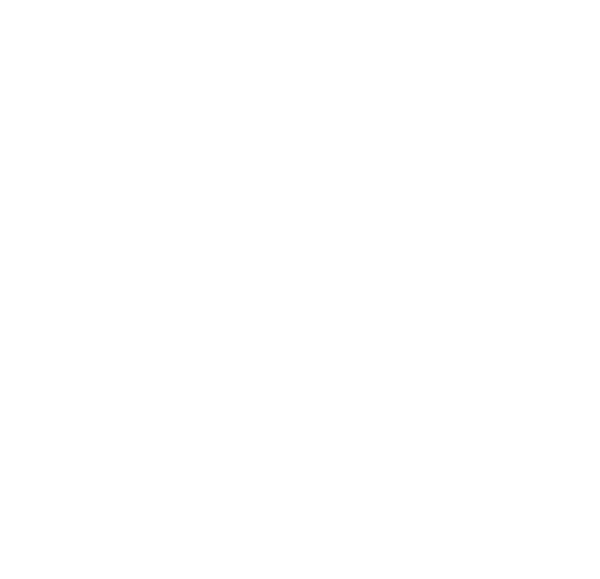

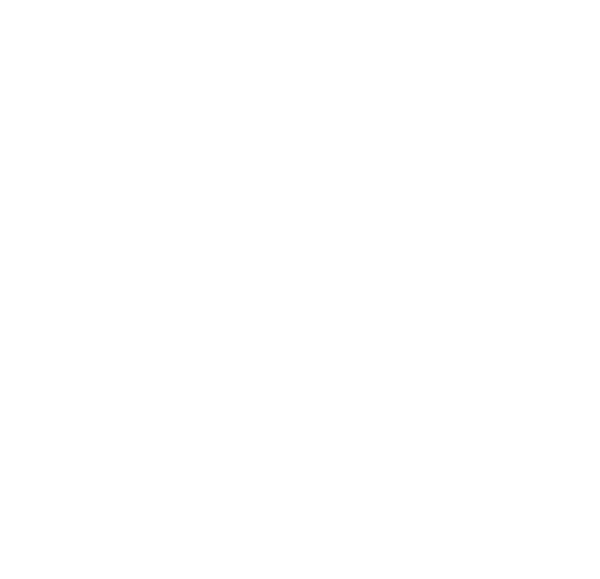

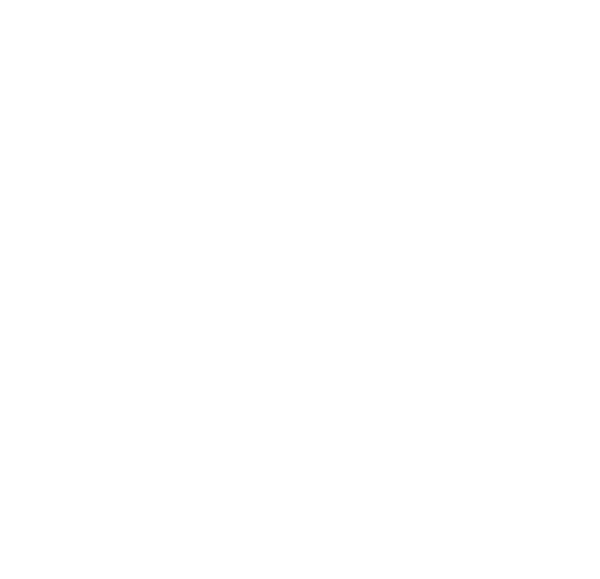

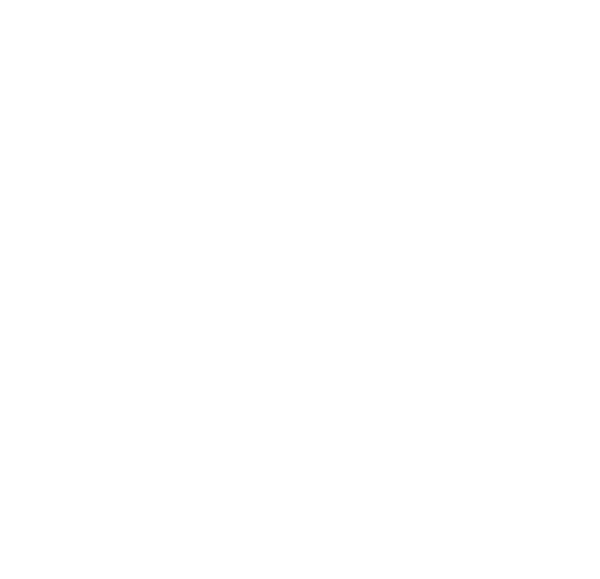

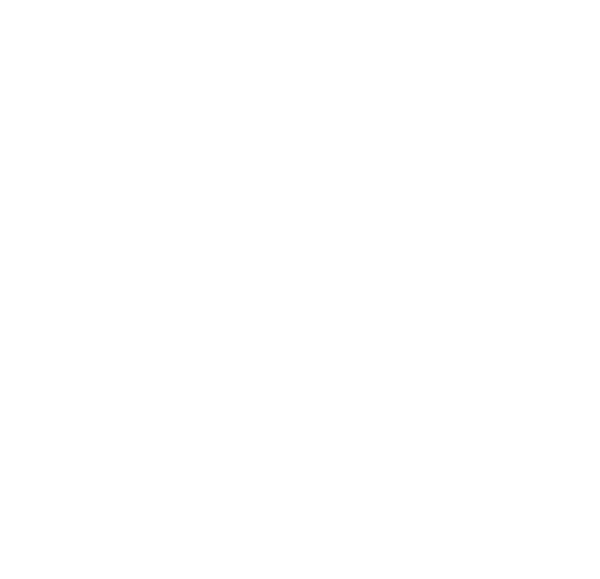

In [48]:
f = collectorEvolution('munhoz,cbr',min_year=1990,freq='4A')

f.axes[-1].get_xaxis().set_visible(False)
f.axes[-1].get_yaxis().set_visible(False)

# Remove last two axes
f.delaxes(f.axes[-1])
f.delaxes(f.axes[-1])

In [49]:
#f.savefig('ub_cwn_munhoz_collabs.png',dpi=200, bbox_inches='tight')